# Working with intrinsic ephys data stored in NWBv2 files: downloading, loading, and feature extraction
This notebook goes through a basic example of downloading an example Patch-seq based intrinsic ephys data file collected by Allen Institute [description here](https://portal.brain-map.org/explore/classes/multimodal-characterization), and then automatically extracting standardized electrophysiology features from the data file. These data files are stored in [NWBv2 format](https://nwb-schema.readthedocs.io/en/latest/format.html#intracellular-electrophysiology), which is an open data format for electrophysiology data. This notebook is based on the IPFX documentation available [here](https://ipfx.readthedocs.io/en/latest/).

## Using IPFX for dataset loading and analysis

[IPFX](https://github.com/AllenInstitute/ipfx) is a great Intrinsic Physiology Feature eXtraction library developed by Allen Institute. It works well with ephys data files stored in NWBv2 format and has nice features for loading files, automatically extracting features, etc.

In [28]:
# Load IPFX libraries

from ipfx.dataset.create import create_ephys_data_set
from ipfx.data_set_features import extract_data_set_features
from ipfx.utilities import drop_failed_sweeps

# Load pandas library too
import pandas as pd

## Download Patch-seq cell-level metadata and visualize

Each row in the <code>experiment_metadata</code> dataframe below corresponds to one recorded cell. The <code>file_manifest</code> variable indicates where all of the raw data is stored and where. Each row indicates one type of data, and the <code>cell_specimen_id</code> column indicates from which cell the data were recorded from. The raw data is stored in different repositories based on the data type.

In [33]:
from ipfx.data_access import get_archive_info
archive_url, file_manifest, experiment_metadata = get_archive_info(dataset="mouse")

experiment_metadata.head()

,project,cell_specimen_id,cell_specimen_name,hemisphere,structure,donor_id,donor_name,biological_sex,age,ethnicity,...,dendrite_type,apical_dendrite_status,neuron_reconstruction_type,cell_soma_normalized_depth,depth_from_pia_um,ephys_session_id,transcriptomics_sample_id,transcriptomics_batch,corresponding_AIT2.3.1_ID,corresponding_AIT2.3.1_alias
0,mIVSCC-MET,601506507,Vip-IRES-Cre;Ai14-331294.04.01.01,left,VISpm4,331294,Vip-IRES-Cre;Ai14-331294,M,P55,NaN,...,sparsely spiny,NaN,full,0.361015,NaN,601506492,PS0810_E1-50_S88,BT035,CS180626100018,Vip Gpc3 Slc18a3
1,mIVSCC-MET,601790961,Sst-IRES-Cre;Ai14-331663.04.01.01,left,VISpm5,331663,Sst-IRES-Cre;Ai14-331663,F,P57,NaN,...,aspiny,NaN,full,0.621829,NaN,601790945,PS0817_E1-50_S19,BT036,CS180626100041,Sst Tac2 Myh4
2,mIVSCC-MET,601803754,Sst-IRES-Cre;Ai14-331663.04.02.02,right,VISp2/3,331663,Sst-IRES-Cre;Ai14-331663,F,P57,NaN,...,sparsely spiny,NaN,full,0.164240,NaN,601803733,PS0817_E1-50_S25,BT036,CS180626100035,Sst Calb2 Pdlim5
3,mIVSCC-MET,601808698,Sst-IRES-Cre;Ai14-331663.04.02.03,right,VISp5,331663,Sst-IRES-Cre;Ai14-331663,F,P57,NaN,...,aspiny,NaN,full,0.483030,NaN,601808619,PS0817_E1-50_S26,BT036,CS180626100043,Sst Hpse Cbln4
4,mIVSCC-MET,601810307,Sst-IRES-Cre;Ai14-331663.04.02.04,right,VISp2/3,331663,Sst-IRES-Cre;Ai14-331663,F,P57,NaN,...,aspiny,NaN,full,0.295656,NaN,601810292,PS0817_E1-50_S27,BT036,CS180626100034,Sst Calb2 Necab1


In [34]:
file_manifest.head()

,file_id,file_name,file_size,sha256_checksum,md5_checksum,technique,file_type,archive,archive_uri,project,cell_specimen_id
0,601506507,601506507.marker,268,305938ce75d55c3f43fbbe2d1d57e203139fa0c357bd73...,ecf2285ccbf5274af7d6a31a855ce950,morphology,marker_swc,BIL,ftp://download.brainlib.org:8811/biccn/zeng/ps...,mIVSCC-MET,601506507.0
1,601790961,601790961.marker,327,84d5ee692a057e55907c82ccbb5b8a894cf2a9eaab9759...,cb0374c42493a567bbb5fa70c4fa79ae,morphology,marker_swc,BIL,ftp://download.brainlib.org:8811/biccn/zeng/ps...,mIVSCC-MET,601790961.0
2,601803754,601803754.marker,426,0aabcc948190e7e50f5ef3aa04c5fefce6b75127d30e85...,df13d1a6c2088edd92eda95ddefebac2,morphology,marker_swc,BIL,ftp://download.brainlib.org:8811/biccn/zeng/ps...,mIVSCC-MET,601803754.0
3,601808698,601808698.marker,320,192fd9ef81c04dec0a18bc51b5be19982c47119d81ebee...,f589c2e0dddc7e5a361b28261ece426a,morphology,marker_swc,BIL,ftp://download.brainlib.org:8811/biccn/zeng/ps...,mIVSCC-MET,601808698.0
4,601810307,601810307.marker,434,fec246a9d6ec3d3b7d026ebb57552ab6a548853d241c95...,fc14084edb78f72b21289accdb38e41e,morphology,marker_swc,BIL,ftp://download.brainlib.org:8811/biccn/zeng/ps...,mIVSCC-MET,601810307.0


## Download intrinsic ephys data from DANDI data archive for one cell

We'll download intrinsic ephys data for one cell shown below (<code>cell_specimen_id == 601790961</code>).

In [36]:
import urllib.request

row = file_manifest.query('cell_specimen_id == 601790961 & technique == "intracellular_electrophysiology"')
archive_uri = row['archive_uri'].values[0]
file_name = row['file_name'].values[0]
print('Intrinsic ephys file url: ' + archive_uri)
print('Intrinsic ephys file name: ' + file_name)

print('downloading data for cell from DANDI...')
urllib.request.urlretrieve(archive_uri, file_name)
print('data downloaded!')


https://girder.dandiarchive.org/api/v1/item/5edb2e312dace54b6f9b39b3/download
sub-601462951_ses-601790945_icephys.nwb
downloading data for cell from DANDI...
data downloaded!


## Load downloaded intrinsic ephys NWBv2 file into IPFX data structure

We're now going to use IPFX utilities to load the NWBv2 data file that we just downloaded into a specific IPFX-based data structure that makes it easy to work with the NWBv2 file type.

In [39]:
from ipfx.dataset.create import create_ephys_data_set
from ipfx.utilities import drop_failed_sweeps

# Create Ephys Data Set

print('loading dataset into data structure...')
#nwb_file_name = '/Users/stripathy/Downloads/sub-601462951_ses-601810292_icephys.nwb'
data_set = create_ephys_data_set(nwb_file=file_name) ##loads nwb file into ipfx data structure

# Drop failed sweeps: sweeps with incomplete recording or failing QC criteria
drop_failed_sweeps(data_set)


loading dataset into data structure...


## Extract ephys features using IPFX

We're now going to use a canned IPFX function called <code>extract_data_set_features</code> to extract a number of features from the raw ephys data file that we just loaded in. Take a look at what is stored in each of the output variables.

In [50]:
from ipfx.data_set_features import extract_data_set_features

# Calculate ephys features
cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)

# print cell_record
cell_record

/Users/stripathy/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/stripathy/anaconda3/lib/python3.7/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
/Users/stripathy/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/stri

{'rheobase_sweep_num': 35,
 'thumbnail_sweep_num': 37,
 'vrest': -80.4909348487854,
 'ri': 157.421812415123,
 'sag': 0.035202305763959885,
 'tau': 17.4862794790775,
 'vm_for_sag': -98.50001,
 'f_i_curve_slope': 0.39238289729191633,
 'adaptation': 0.20960533746599339,
 'latency': 0.028739999999999988,
 'avg_isi': 120.85714285714288,
 'upstroke_downstroke_ratio_long_square': 2.100436206191834,
 'peak_v_long_square': 6.78125,
 'peak_t_long_square': 0.5824400000000001,
 'trough_v_long_square': -68.25,
 'trough_t_long_square': 0.58388,
 'fast_trough_v_long_square': -68.03125,
 'fast_trough_t_long_square': 0.5837399999999999,
 'slow_trough_v_long_square': None,
 'slow_trough_t_long_square': None,
 'threshold_v_long_square': -54.093753814697266,
 'threshold_i_long_square': 110,
 'threshold_t_long_square': 0.58206,
 'upstroke_downstroke_ratio_ramp': 2.085217661323286,
 'peak_v_ramp': 13.71875,
 'peak_t_ramp': 5.38462,
 'trough_v_ramp': -66.8125,
 'trough_t_ramp': 5.38602,
 'fast_trough_v_ramp'

## Plot one sweep from ephys file

Good electrophysiologists (and computational neuroscientists too!) always plot their data before relying on the output of automatic feature extraction pipelines.

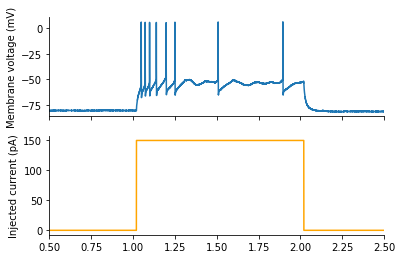

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# these are basic IPFX objects for working with sweeps and sets of sweeps
from ipfx.sweep import Sweep, SweepSet 

sweep_plot_index = 37 # which sweep number do you want to plot?

curr_sweep = data_set.sweep_set(sweep_plot_index).sweeps[0]
t = curr_sweep.t
v = curr_sweep.v
i = curr_sweep.i

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(t, v)
axes[0].set_xlim(.5, 2.5)
axes[0].set_ylabel("Membrane voltage (mV)")

axes[1].plot(t, i, c="orange")
axes[1].set_ylabel("Injected current (pA)")

sns.despine()

## Extract features from long step current injection sweeps

We'll now use a set of specific utilities for extracting spikes and spike train features from a set of "standard" 1 second long step current injection stimuli.

In [54]:
from ipfx.feature_extractor import SpikeFeatureExtractor, SpikeTrainFeatureExtractor

import ipfx.stimulus_protocol_analysis as spa
from ipfx.epochs import get_stim_epoch
import matplotlib.pyplot as plt


# get sweep table of Long Square sweeps
long_square_table = data_set.filtered_sweep_table(
    stimuli=data_set.ontology.long_square_names
)
long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)

# Select epoch corresponding to the actual recording from the sweeps
# and align sweeps so that the experiment would start at the same time
long_square_sweeps.select_epoch("recording")
long_square_sweeps.align_to_start_of_epoch("experiment")

# find the start and end time of the stimulus
# (treating the first sweep as representative)
stim_start_index, stim_end_index = get_stim_epoch(long_square_sweeps.i[0])
stim_start_time = long_square_sweeps.t[0][stim_start_index]
stim_end_time = long_square_sweeps.t[0][stim_end_index]

# build the extractors
spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time)
sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time)

# run the analysis and print out a few of the features
long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=-100.0)
data = long_square_analysis.analyze(long_square_sweeps)

fields_to_print = [
    'tau',
    'v_baseline',
    'input_resistance',
    'vm_for_sag',
    'fi_fit_slope',
    'sag',
    'rheobase_i'
]

for field in fields_to_print:
    print("%s: %s" % (field, str(data[field])))


/Users/stripathy/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/stripathy/anaconda3/lib/python3.7/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]


tau: 0.0174862794790775
v_baseline: -80.4909348487854
input_resistance: 157.421812415123
vm_for_sag: -98.50001
fi_fit_slope: 0.39239074510681843
sag: 0.035204436630010605
rheobase_i: 110.0


## Plot a FI curve (Spike frequency vs Injected current) 
This uses the <code>data</code> variable generated above 

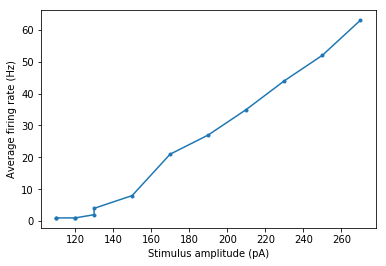

In [55]:
# Plot stimulus amplitude vs. firing rate
spiking_sweeps = data['spiking_sweeps'].sort_values(by='stim_amp')
plt.plot(spiking_sweeps.stim_amp,
         spiking_sweeps.avg_rate, '.-')
plt.xlabel('Stimulus amplitude (pA)')
plt.ylabel('Average firing rate (Hz)')

plt.show()

## Output extracted features from long square pulses for downstream analysis

In [57]:
def summarize_cell_ephys_features(lsa_results):
    hero_keep_features = ['adapt', 'avg_rate', 'first_isi', 'isi_cv', 'latency', 'mean_isi', 'median_isi', 
                          'stim_amp']
    rheo_keep_features = ['threshold_v', 'peak_v', 'trough_v', 
     'fast_trough_v', 'adp_v', 'width', 'upstroke_downstroke_ratio', 'peak_t', 'fast_trough_t', 'trough_t']
    
    overall_cell_keep_features = ['v_baseline', 'rheobase_i', 'fi_fit_slope', 
                                  'sag', 'vm_for_sag', 'input_resistance', 'tau']
    
    hero_small_dict = lsa_results['hero_sweep'][hero_keep_features]
    rheobase_sweep_index = lsa_results['rheobase_sweep'].name
    rheobase_sweep = lsa_results['spikes_set'][rheobase_sweep_index].iloc[0]
    
    rheo_spike_small_dict = rheobase_sweep[rheo_keep_features]
    rheo_first_isi = lsa_results['rheobase_sweep']['first_isi']
    rheo_spike_small_dict['rheo_first_isi'] = rheo_first_isi

    spike_comb_dict = {**hero_small_dict, **rheo_spike_small_dict}

    overall_cell_features = {x: lsa_results[x] for x in overall_cell_keep_features if x in lsa_results}
    final_cell_feature_dict = {**spike_comb_dict, **overall_cell_features}
    return(final_cell_feature_dict)

In [58]:
summarize_cell_ephys_features(data)

{'adapt': 0.20960533746599339,
 'avg_rate': 8.000160003200065,
 'first_isi': 0.023479999999999945,
 'isi_cv': 1.0965321022292043,
 'latency': 0.028739999999999988,
 'mean_isi': 0.12085714285714287,
 'median_isi': 0.05242000000000013,
 'stim_amp': 150.0,
 'threshold_v': -54.093754,
 'peak_v': 6.78125,
 'trough_v': -68.25,
 'fast_trough_v': -68.03125,
 'adp_v': nan,
 'width': 0.0005399999999999849,
 'upstroke_downstroke_ratio': 2.100436206191834,
 'peak_t': 0.5824400000000001,
 'fast_trough_t': 0.5837399999999999,
 'trough_t': 0.58388,
 'rheo_first_isi': nan,
 'v_baseline': -80.4909348487854,
 'rheobase_i': 110.0,
 'fi_fit_slope': 0.39239074510681843,
 'sag': 0.035204436630010605,
 'vm_for_sag': -98.50001,
 'input_resistance': 157.421812415123,
 'tau': 0.0174862794790775}